In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
# Show matplotlib plots inline
%matplotlib inline
bases_dir = "season_1_data"

# Load the data path
TRAIN_DATA_DIR = "season_1_data/training_data"
TEST_DATA_DIR = "season_1_data/test_data"

# All the data dirs
CLUSTER_MAP_SHEET_DIR = "cluster_map"
ORDER_SHEET_DIR = "order_data"
TRAFFIC_SHEET_DIR = "traffic_data"
WEATHER_SHEET_DIR = "weather_data"
POI_SHEET_DIR = "poi_data"

### MAPE

In [2]:
from sklearn.utils import assert_all_finite
def MAPE(y_pred, y_true):
    y_true = np.asanyarray(y_true)
    y_pred = np.asanyarray(y_pred)
    assert_all_finite(y_true)
    assert_all_finite(y_pred)
    #Filter zero values in y_true
    sel = (y_true != 0)
    y_true = y_true[sel]
    y_pred = y_pred[sel]
    
    return np.mean(np.abs((y_true - y_pred) / y_true))

### Standard Indexing 

In [309]:
# build one standard time slots index in each distric_id
# district_id: 66, date: 21 + 5, time_slots = 144 
train_std_index = pd.DataFrame()
time_slot_index = []
id_index = []
date_index = []
week_index = []
for date, i_date in train_order.groupby('date'):
    for i_id in range(1,67):
        for i_slot in range(1,145):
            time_slot_index.append(int(i_slot))
            id_index.append(i_id)
            date_index.append(date)
            
train_std_index['district_id'] =  id_index
train_std_index['time'] = time_slot_index
train_std_index['date'] = date_index
train_std_index['week'] = pd.to_datetime(train_std_index.date).map(lambda x: x.isoweekday())

train_std_index.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199584 entries, 0 to 199583
Data columns (total 4 columns):
district_id    199584 non-null int64
time           199584 non-null int64
date           199584 non-null object
week           199584 non-null int64
dtypes: int64(3), object(1)
memory usage: 6.1+ MB


In [288]:
# standard index of 144*21
std_index_weather = pd.DataFrame()
time_slot_index = []
id_index = []
date_index = []
week_index = []
for date, i_date in train_weather.groupby('date'):
    for i_slot in range(1,145):
        time_slot_index.append(int(i_slot))
        date_index.append(date)
            
std_index_weather['date'] = date_index
std_index_weather['week'] = pd.to_datetime(std_index_weather.date).map(lambda x: x.isoweekday())
std_index_weather['time'] = time_slot_index

std_index_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3024 entries, 0 to 3023
Data columns (total 3 columns):
date    3024 non-null object
week    3024 non-null int64
time    3024 non-null int64
dtypes: int64(2), object(1)
memory usage: 70.9+ KB


In [114]:
# build one standard time slots index in each distric_id
# district_id: 66, time_slots = 144 
std_index = pd.DataFrame()
time_slot_index = []
id_index = []

for i_id in range(1,67):
    for i_slot in range(1,145):
        time_slot_index.append(int(i_slot))
        id_index.append(i_id)
      
std_index['district_id'] =  id_index
std_index['time'] = time_slot_index

std_index.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9504 entries, 0 to 9503
Data columns (total 2 columns):
district_id    9504 non-null int64
time           9504 non-null int64
dtypes: int64(2)
memory usage: 148.6 KB


## Data Load

The training data: 2016-01-01 to 2016-01-21.<br>
the number of order and traffic values for each items = `144*21*66 = 199584` <br>
the number of weather values for each items = `144*21 = 3024`

The test data: 2016-01-22, 24, 26, 28 and 30. <br>
the number of order and traffic values for each items = `9*3*5*66 = 8910` <br>
the number of weather values for each items = `9*3*5 = 135`

The submit data: 9 time slots (i.e. 46, 58, 70, 82, 94, 106, 118, 130, and 142) in each distrct at the days in test data.<br>
the number of rows is 2838? why.


There are many time slots missing. The empty slots should be found first. build a standard time slots index in each district_id to compare with them, and then I choose using interpolation to fill in missing data by copying the values from nearest neighbors.




### Order Data

In [246]:
import glob

# Load all the order data as train_order and test_order
train_order_path = os.path.join(TRAIN_DATA_DIR, ORDER_SHEET_DIR)
test_order_path = os.path.join(TEST_DATA_DIR, ORDER_SHEET_DIR)

train_order_files = glob.glob(os.path.join(train_order_path, "*.csv"))
test_order_files = glob.glob(os.path.join(test_order_path, "*.csv"))

train_order = pd.concat((pd.read_csv(f) for f in train_order_files))
test_order = pd.concat((pd.read_csv(f) for f in test_order_files))

##### Train order

In [247]:
train_order[:2]

,district_id,date,week,time,demand,supply,gap
0,1,2016-01-01,5,1,187,178.0,9.0
1,1,2016-01-01,5,2,198,191.0,7.0


In [248]:
train_order.describe()

,district_id,week,time,demand,supply,gap
count,163491.000000,163491.000000,163491.000000,163491.000000,163491.000000,163491.000000
mean,31.732909,4.011780,78.289814,52.239047,42.963552,9.275495
std,18.562100,1.999978,39.426369,112.348401,81.039485,49.817422
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,16.000000,2.000000,49.000000,4.000000,3.000000,0.000000
50%,31.000000,4.000000,80.000000,12.000000,10.000000,1.000000
75%,47.000000,6.000000,112.000000,47.000000,41.000000,4.000000
max,66.000000,7.000000,144.000000,4362.000000,1084.000000,3872.000000


In [ ]:
# show the average time slots' number in each day
#slot_number_each_day = []
#for date, drp in train_order.groupby('date'):
#    slot_number_each_day.append(len(drp.time) / 66.)
#slot_number_each_day

In [345]:
## Interpolate the missed values of train order data
full_order = train_std_index.merge(train_order, on=['district_id', 'time', 'week', 'date'], how='left')

full_order.demand = full_order.demand.interpolate()
full_order.supply = full_order.supply.interpolate()
full_order.gap = full_order.gap.interpolate()
full_order.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199584 entries, 0 to 199583
Data columns (total 7 columns):
district_id    199584 non-null int64
time           199584 non-null int64
date           199584 non-null object
week           199584 non-null int64
demand         199584 non-null float64
supply         199584 non-null float64
gap            199584 non-null float64
dtypes: float64(3), int64(3), object(1)
memory usage: 12.2+ MB


##### Test order

In [522]:
test_order.describe()

,district_id,week,time,demand,supply,gap
count,7924.000000,7924.000000,7924.000000,7924.000000,7924.000000,7924.000000
mean,32.690687,4.772211,93.761736,70.417087,56.664563,13.752524
std,18.737809,1.721923,29.544495,140.675716,99.612180,57.930333
min,1.000000,2.000000,43.000000,1.000000,0.000000,0.000000
25%,17.000000,4.000000,68.000000,5.000000,4.000000,0.000000
50%,32.000000,5.000000,92.000000,16.000000,14.000000,1.000000
75%,48.000000,6.000000,117.000000,70.000000,61.000000,5.000000
max,66.000000,7.000000,141.000000,1878.000000,783.000000,1164.000000


In [507]:
## test order standard index

test_std_index = pd.DataFrame()
time_slot_index = []
id_index = []
date_index = []
for i_day, drp in test_order.groupby('date'):
    for i_slot, trp in drp.groupby('time'):
        for i_id, irp in trp.groupby('district_id'):
            time_slot_index.append(int(i_slot))
            id_index.append(i_id)
            date_index.append(i_day)
            
test_std_index['district_id'] =  id_index
test_std_index['date'] = date_index
test_std_index['week'] = pd.to_datetime(test_std_index.date).map(lambda x: x.isoweekday())
test_std_index['time'] = time_slot_index

test_std_index.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7924 entries, 0 to 7923
Data columns (total 4 columns):
district_id    7924 non-null int64
date           7924 non-null object
week           7924 non-null int64
time           7924 non-null int64
dtypes: int64(3), object(1)
memory usage: 247.7+ KB


In [521]:
## Interpolate the missed values of train order data
full_test_order = test_std_index.merge(test_order, on=['district_id', 'time', 'week', 'date'], how='left')

full_test_order.demand = full_test_order.demand.interpolate()
full_test_order.supply = full_test_order.supply.interpolate()
full_test_order.gap = full_test_order.gap.interpolate()
full_test_order.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7924 entries, 0 to 7923
Data columns (total 7 columns):
district_id    7924 non-null int64
date           7924 non-null object
week           7924 non-null int64
time           7924 non-null int64
demand         7924 non-null int64
supply         7924 non-null float64
gap            7924 non-null float64
dtypes: float64(2), int64(4), object(1)
memory usage: 495.2+ KB


In [509]:
full_test_order[:2]

,district_id,date,week,time,demand,supply,gap
0,1,2016-01-22,5,43,74,70.0,4.0
1,2,2016-01-22,5,43,20,19.0,1.0


### Weather data

In [517]:
# Load all the weather data as train_weather and test_weather
train_weather_path = os.path.join(TRAIN_DATA_DIR, WEATHER_SHEET_DIR)
test_weather_path = os.path.join(TEST_DATA_DIR, WEATHER_SHEET_DIR)

train_weather_files = glob.glob(os.path.join(train_weather_path, "*.csv"))
test_weather_files = glob.glob(os.path.join(test_weather_path, "*.csv"))

train_weather = pd.concat((pd.read_csv(f) for f in train_weather_files))
test_weather = pd.concat((pd.read_csv(f) for f in test_weather_files))

##### Train weather

In [347]:
train_weather[-30:-27]

,date,week,time,Weather,temperature,PM2.5
7,2016-01-21,4,59,4,1.0,49
8,2016-01-21,4,115,4,1.0,44
9,2016-01-21,4,117,4,1.0,44


In [348]:
## interpolate the missed values in training weather data
std_index1[:2]

,time,date,week
0,1,2016-01-21,4
1,2,2016-01-21,4


In [349]:
full_weather = std_index_weather.merge(train_weather, on=['date','week','time'], how='left')
full_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3024 entries, 0 to 3023
Data columns (total 6 columns):
date           3024 non-null object
week           3024 non-null int64
time           3024 non-null int64
Weather        2670 non-null float64
temperature    2670 non-null float64
PM2.5          2670 non-null float64
dtypes: float64(3), int64(2), object(1)
memory usage: 165.4+ KB


In [350]:
#Interpolate
full_weather['PM2.5'] = full_weather['PM2.5'].interpolate(method='nearest').bfill()
full_weather['Weather'] = full_weather['Weather'].interpolate(method='nearest').bfill()
full_weather['temperature'] = full_weather['temperature'].interpolate(method='nearest').ffill().bfill()

full_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3024 entries, 0 to 3023
Data columns (total 6 columns):
date           3024 non-null object
week           3024 non-null int64
time           3024 non-null int64
Weather        3024 non-null float64
temperature    3024 non-null float64
PM2.5          3024 non-null float64
dtypes: float64(3), int64(2), object(1)
memory usage: 165.4+ KB


##### Test weather

In [518]:
test_weather[:2]

,date,week,time,Weather,temperature,PM2.5
0,2016-01-22,5,43,2,2.0,51
1,2016-01-22,5,45,2,2.0,51


In [519]:
test_weather.describe()

,week,time,Weather,temperature,PM2.5
count,78.000000,78.000000,78.000000,78.000000,78.000000
mean,4.628205,95.846154,2.807692,2.294872,70.717949
std,1.838329,31.572254,1.721202,3.657794,15.842486
min,2.000000,43.000000,1.000000,-7.000000,50.000000
25%,2.000000,69.000000,1.000000,1.250000,58.000000
50%,5.000000,93.000000,3.000000,3.000000,65.000000
75%,6.000000,124.500000,4.000000,5.000000,81.000000
max,7.000000,141.000000,9.000000,7.000000,101.000000


In [ ]:
## test weather standard index
test_std_index = pd.DataFrame()
time_slot_index = []
id_index = []
date_index = []
for i_day, drp in test_order.groupby('date'):
    for i_slot, trp in drp.groupby('time'):
        for i_id, irp in trp.groupby('district_id'):
            time_slot_index.append(int(i_slot))
            id_index.append(i_id)
            date_index.append(i_day)
            
test_std_index['district_id'] =  id_index
test_std_index['date'] = date_index
test_std_index['week'] = pd.to_datetime(test_std_index.date).map(lambda x: x.isoweekday())
test_std_index['time'] = time_slot_index

test_std_index.info()

In [559]:
## test weather standard index
## there are too many values missed in weather data, so the test_order data is used to build the weather standart index.

test_date_index = []
test_time_index = []
for date, drp in test_order.groupby('date'):
    test_date_index.append(date)

for date, drp in test_order.groupby('time'):
    test_time_index.append(date)

test_weather_std_index = pd.DataFrame()
time_slot_index = []
date_index = []
for i_date in test_date_index:
    for i_slot in test_time_index:
        date_index.append(i_date)
        time_slot_index.append(int(i_slot))

test_weather_std_index['date'] = date_index
test_weather_std_index['week'] = pd.to_datetime(test_weather_std_index.date).map(lambda x: x.isoweekday())
test_weather_std_index['time'] = time_slot_index
test_weather_std_index.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 3 columns):
date    135 non-null object
week    135 non-null int64
time    135 non-null int64
dtypes: int64(2), object(1)
memory usage: 3.2+ KB


In [562]:
full_test_weather = test_weather_std_index.merge(test_weather, on=['date','week','time'], how='left')
full_test_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135 entries, 0 to 134
Data columns (total 6 columns):
date           135 non-null object
week           135 non-null int64
time           135 non-null int64
Weather        78 non-null float64
temperature    78 non-null float64
PM2.5          78 non-null float64
dtypes: float64(3), int64(2), object(1)
memory usage: 7.4+ KB


In [563]:
# Interpolate
full_test_weather['PM2.5'] = full_test_weather['PM2.5'].interpolate(method='nearest').bfill()
full_test_weather['Weather'] = full_test_weather['Weather'].interpolate(method='nearest').bfill()
full_test_weather['temperature'] = full_test_weather['temperature'].interpolate(method='nearest').ffill().bfill()

full_test_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135 entries, 0 to 134
Data columns (total 6 columns):
date           135 non-null object
week           135 non-null int64
time           135 non-null int64
Weather        135 non-null float64
temperature    135 non-null float64
PM2.5          135 non-null float64
dtypes: float64(3), int64(2), object(1)
memory usage: 7.4+ KB


### POI Data

In [352]:
# Load all the poi data
train_poi_path = os.path.join(TRAIN_DATA_DIR, POI_SHEET_DIR)
test_poi_path = os.path.join(TEST_DATA_DIR, POI_SHEET_DIR)

train_poi_files = glob.glob(os.path.join(train_poi_path, "*.csv"))
test_poi_files = glob.glob(os.path.join(test_poi_path, "*.csv"))

train_poi = pd.concat((pd.read_csv(f) for f in train_poi_files))
test_poi = pd.concat((pd.read_csv(f) for f in test_poi_files))

In [565]:
train_poi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66 entries, 0 to 65
Columns: 156 entries, 1_1 to district_id
dtypes: int64(156)
memory usage: 81.0 KB


In [564]:
test_poi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66 entries, 0 to 65
Columns: 156 entries, 1_1 to district_id
dtypes: int64(156)
memory usage: 81.0 KB


### Traffic Data

In [354]:
# Load all the traffic data
train_traffic_path = os.path.join(TRAIN_DATA_DIR, TRAFFIC_SHEET_DIR)
test_traffic_path = os.path.join(TEST_DATA_DIR, TRAFFIC_SHEET_DIR)

train_traffic_files = glob.glob(os.path.join(train_traffic_path, "*.csv"))
test_traffic_files = glob.glob(os.path.join(test_traffic_path, "*.csv"))

train_traffic = pd.concat((pd.read_csv(f) for f in train_traffic_files))
test_traffic = pd.concat((pd.read_csv(f) for f in test_traffic_files))

##### Train traffic

In [355]:
train_traffic[:2]

,traffic_1,traffic_2,traffic_3,traffic_4,date,week,time,district_id
0,1399,318,102,94,2016-01-01,5,2,1
1,1491,322,99,64,2016-01-01,5,3,1


In [356]:
train_traffic[train_traffic.district_id == 54][:2]

,traffic_1,traffic_2,traffic_3,traffic_4,date,week,time,district_id


In [357]:
train_traffic.describe()

,traffic_1,traffic_2,traffic_3,traffic_4,week,time,district_id
count,193553.000000,193553.000000,193553.00000,193553.000000,193553.000000,193553.000000,193553.000000
mean,603.522338,128.780282,38.72173,26.097756,4.007672,72.641271,33.197594
std,704.277587,216.896741,67.77862,42.035663,2.005752,41.189142,19.025079
min,0.000000,0.000000,0.00000,0.000000,1.000000,2.000000,1.000000
25%,147.000000,16.000000,5.00000,3.000000,2.000000,37.000000,17.000000
50%,323.000000,49.000000,15.00000,10.000000,4.000000,73.000000,33.000000
75%,779.000000,146.000000,43.00000,30.000000,6.000000,108.000000,49.000000
max,4223.000000,2084.000000,863.00000,486.000000,7.000000,144.000000,66.000000


In [571]:
full_traffic = train_std_index.merge(train_traffic, on=['district_id','date', 'week', 'time'], how = 'left')
full_traffic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199584 entries, 0 to 199583
Data columns (total 8 columns):
district_id    199584 non-null int64
time           199584 non-null int64
date           199584 non-null object
week           199584 non-null int64
traffic_1      193553 non-null float64
traffic_2      193553 non-null float64
traffic_3      193553 non-null float64
traffic_4      193553 non-null float64
dtypes: float64(4), int64(3), object(1)
memory usage: 13.7+ MB


In [425]:
full_traffic[:2]

,district_id,time,date,week,traffic_1,traffic_2,traffic_3,traffic_4
0,1,1,2016-01-01,5,NaN,NaN,NaN,NaN
1,1,2,2016-01-01,5,1399.0,318.0,102.0,94.0


In [360]:
full_traffic[full_data.district_id == 54][:2]

NameError: name 'full_data' is not defined

**Notes：**

The traffic values on district 54 are missing. How to fill these values?

We can use the traffic data of district 57 to fill it, but I have not find a way to implement it.

Now, just to fill these data using interpolate method.

In [331]:
full_traffic.loc[57,:]

district_id             1
time                   58
date           2016-01-01
week                    5
traffic_1            1450
traffic_2             313
traffic_3             109
traffic_4              84
Name: 57, dtype: object

In [423]:
full_traffic.groupby('district_id').iloc[54,:]['traffic_1'] = full_traffic.groupby('district_id').iloc[57,:]['traffic_1']
full_traffic.groupby('district_id').iiloc[54,:]['traffic_2'] = full_traffic.groupby('district_id').iloc[57,:]['traffic_2']

AttributeError: Cannot access callable attribute 'iloc' of 'DataFrameGroupBy' objects, try using the 'apply' method

In [426]:
full_traffic['traffic_1'] = full_traffic['traffic_1'].interpolate(method='nearest').bfill()
full_traffic['traffic_2'] = full_traffic['traffic_2'].interpolate(method='nearest').bfill()
full_traffic['traffic_3'] = full_traffic['traffic_3'].interpolate(method='nearest').ffill().bfill()
full_traffic['traffic_4'] = full_traffic['traffic_4'].interpolate(method='nearest').ffill().bfill()
full_traffic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199584 entries, 0 to 199583
Data columns (total 8 columns):
district_id    199584 non-null int64
time           199584 non-null int64
date           199584 non-null object
week           199584 non-null int64
traffic_1      199584 non-null float64
traffic_2      199584 non-null float64
traffic_3      199584 non-null float64
traffic_4      199584 non-null float64
dtypes: float64(4), int64(3), object(1)
memory usage: 13.7+ MB


##### Test traffic

In [566]:
test_traffic[:2]

,traffic_1,traffic_2,traffic_3,traffic_4,week,date,time,district_id
0,1392.0,204.0,86.0,45.0,5.0,2016-01-22,43.0,1
1,1454.0,269.0,102.0,73.0,5.0,2016-01-22,44.0,1


In [567]:
test_traffic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8386 entries, 0 to 1755
Data columns (total 8 columns):
traffic_1      8381 non-null float64
traffic_2      8381 non-null float64
traffic_3      8381 non-null float64
traffic_4      8381 non-null float64
week           8381 non-null float64
date           8381 non-null object
time           8381 non-null float64
district_id    8386 non-null int64
dtypes: float64(6), int64(1), object(1)
memory usage: 589.6+ KB


In [570]:
test_std_index.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7924 entries, 0 to 7923
Data columns (total 4 columns):
district_id    7924 non-null int64
date           7924 non-null object
week           7924 non-null int64
time           7924 non-null int64
dtypes: int64(3), object(1)
memory usage: 247.7+ KB


In [572]:
## The traffic standard index is same with which of test order index.
## Interpolate the missed values of train order data
full_test_traffic = test_std_index.merge(test_traffic, on=['district_id','date', 'week', 'time'], how = 'left')

full_test_traffic['traffic_1'] = full_test_traffic['traffic_1'].interpolate(method='nearest').bfill()
full_test_traffic['traffic_2'] = full_test_traffic['traffic_2'].interpolate(method='nearest').bfill()
full_test_traffic['traffic_3'] = full_test_traffic['traffic_3'].interpolate(method='nearest').ffill().bfill()
full_test_traffic['traffic_4'] = full_test_traffic['traffic_4'].interpolate(method='nearest').ffill().bfill()
full_test_traffic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7924 entries, 0 to 7923
Data columns (total 8 columns):
district_id    7924 non-null int64
date           7924 non-null object
week           7924 non-null int64
time           7924 non-null int64
traffic_1      7924 non-null float64
traffic_2      7924 non-null float64
traffic_3      7924 non-null float64
traffic_4      7924 non-null float64
dtypes: float64(4), int64(3), object(1)
memory usage: 557.2+ KB


### Submited Data

In [440]:
# Load test.csv
test_data = pd.read_csv('season_1/test.csv', header= None)
test_data.columns = ["district_id", "Time","gap"]
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 3 columns):
district_id    2838 non-null int64
Time           2838 non-null object
gap            2838 non-null int64
dtypes: int64(2), object(1)
memory usage: 66.6+ KB


In [441]:
test_data[:2]

,district_id,Time,gap
0,1,2016-01-22-46,0
1,2,2016-01-22-46,0


In [442]:
test_date =  test_data.Time.map(lambda x: x[:10])
test_time_slice = pd.to_datetime(test_date, unit='s')

test_data["week"] = test_time_slice.map(lambda x: x.isoweekday())
test_data["date"] = test_time_slice.map(lambda x: x.date())
test_data["time"] = test_data.Time.map(lambda x: x[11:]).map(int)

del test_data["gap"]
del test_data["Time"]
test_data[:2]

,district_id,week,date,time
0,1,5,2016-01-22,46
1,2,5,2016-01-22,46


## Data Analysis

### Show the average gap in each weekday

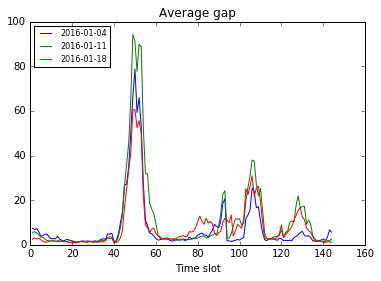

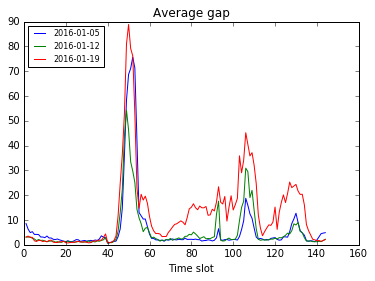

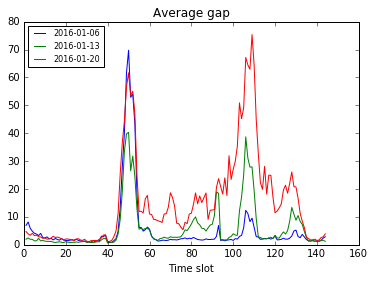

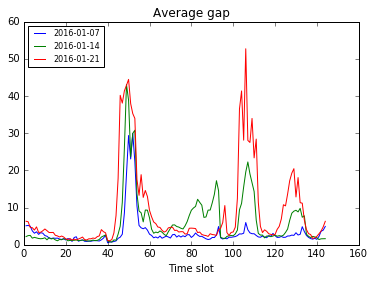

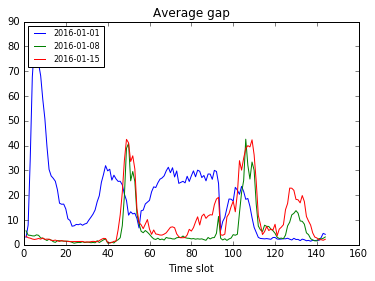

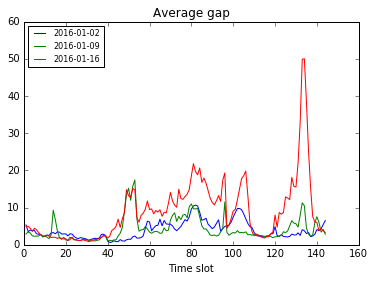

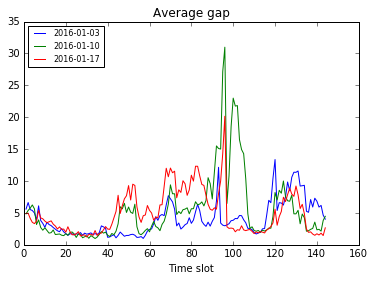

In [400]:
for work, wgr in full_order.groupby('week'):
    plt.figure()
    for date, dgr in wgr.groupby('date'):
        plt.plot(dgr.groupby('time').gap.mean(), label=str(date))
    plt.title('Average gap')
    plt.legend(loc=2,prop={'size':8})
    plt.xlabel('Time slot')

### Show the average gap of each day

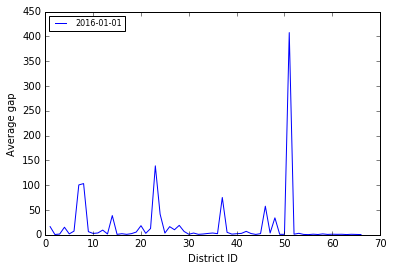

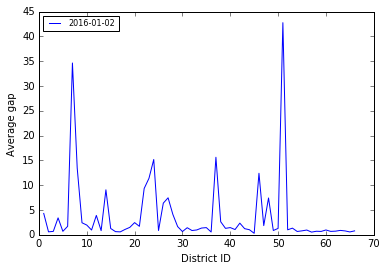

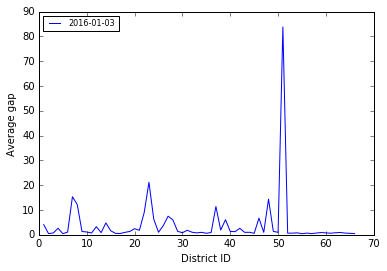

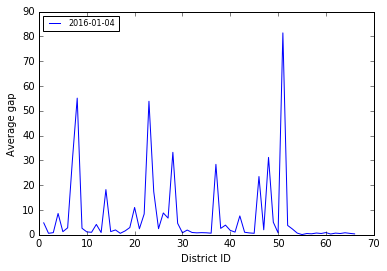

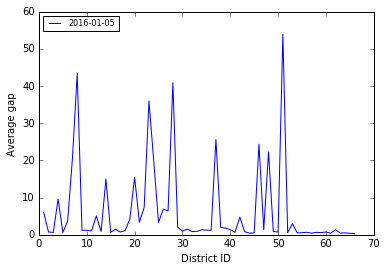

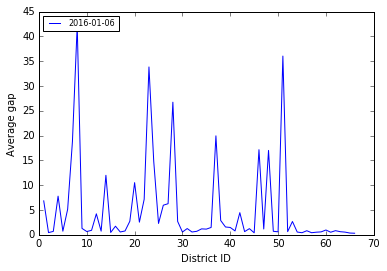

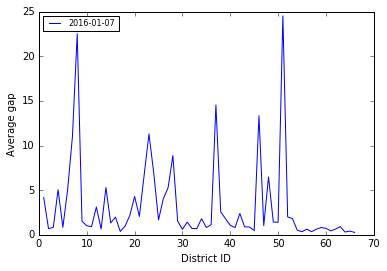

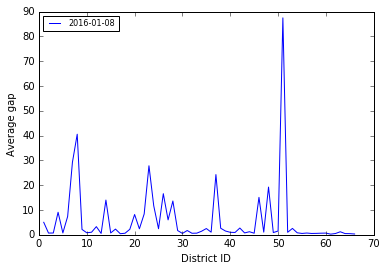

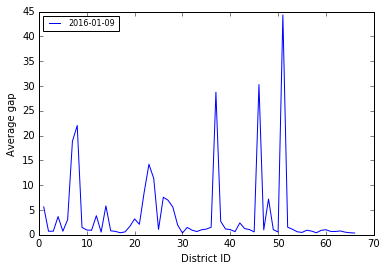

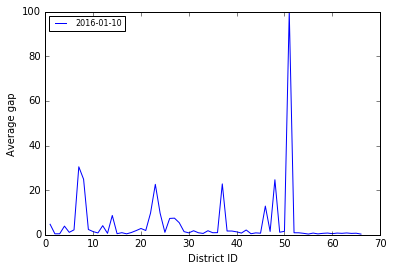

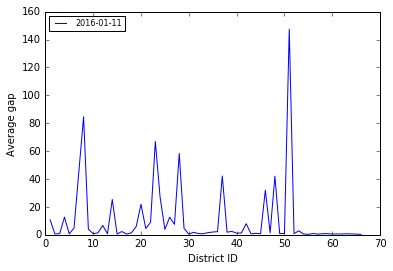

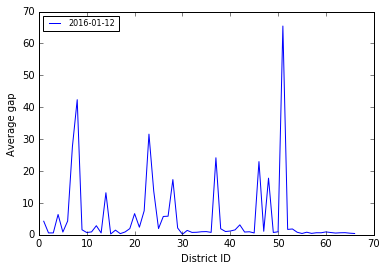

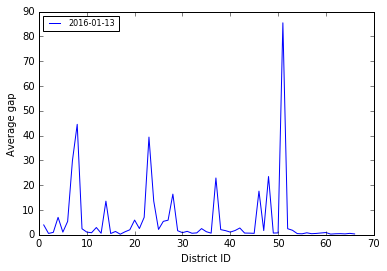

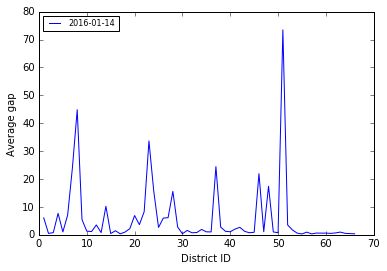

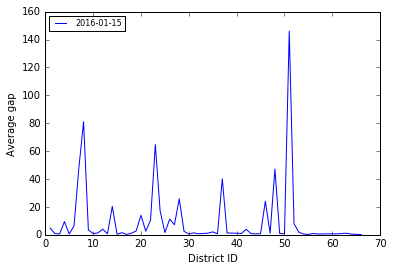

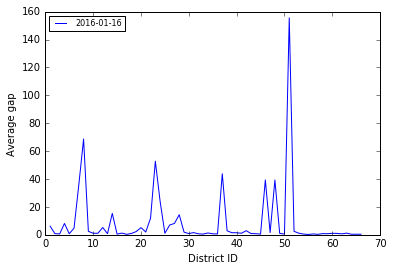

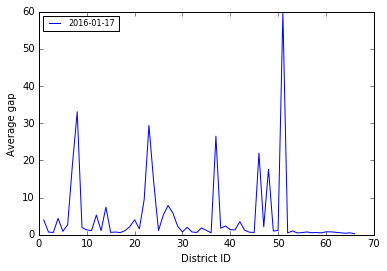

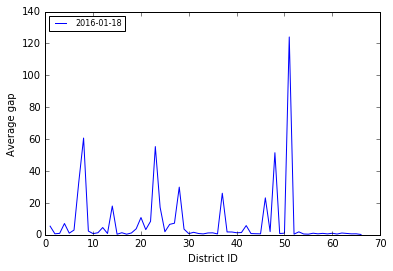

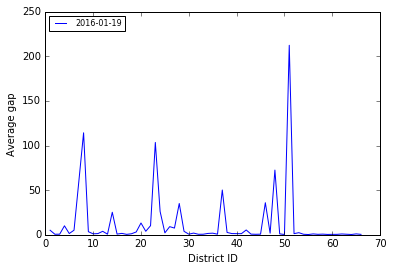

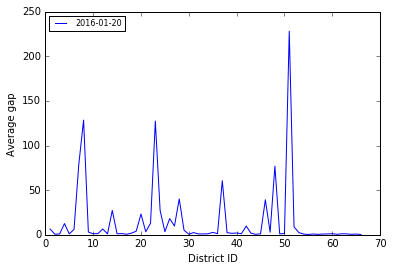

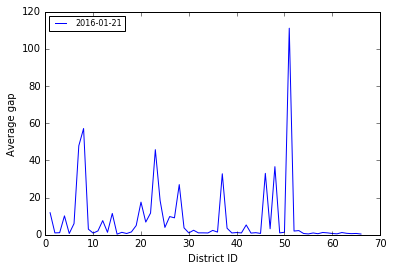

In [399]:
# show the average gap of each day
for date, drp in full_order.groupby('date'):
    
    plt.figure()
    plt.plot(drp.groupby('district_id').gap.mean(), label=str(date))
    #plt.title('Average gap')
    plt.legend(loc=2,prop={'size':8})
    plt.xlabel('District ID')
    plt.ylabel('Average gap')

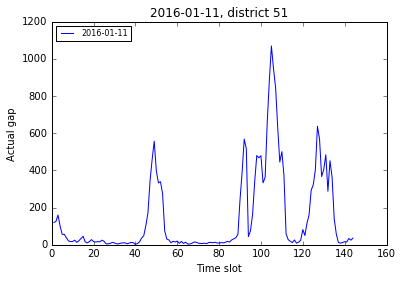

In [421]:
# show the specific district gap info
# 2016-01-11,  district_id = 51

data_temp_specific1 = full_order[full_order.date == '2016-01-11']

for date, dgr in data_temp_specific1[data_temp_specific1.district_id == 51].groupby('date'):
    plt.figure()
    plt.plot(dgr.groupby('time').gap.mean(), label=str(date))
    plt.title('gap')
    plt.legend(loc=2,prop={'size':8})
    plt.title('2016-01-11, district 51')
    plt.xlabel('Time slot')
    plt.ylabel('Actual gap')

### Show the average gap in each week
There are four figures. i.e 4 weeks.<br>
week 1: 1-3<br>
week 2: 4-10<br>
week 3: 11-17<br>
week 4: 18-21<br>

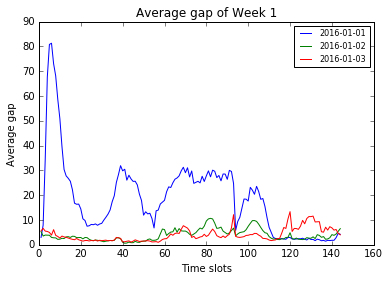

In [392]:
data_temp_week01 = full_order[full_order.date < '2016-01-04']
for date, drp in data_temp_week01.groupby('date'):
    plt.plot(drp.groupby('time').gap.mean(), label=str(date))
    plt.title('Average gap of Week 1')
    plt.legend(loc=1,prop={'size':8})
    plt.xlabel('Time slots')
    plt.ylabel('Average gap')

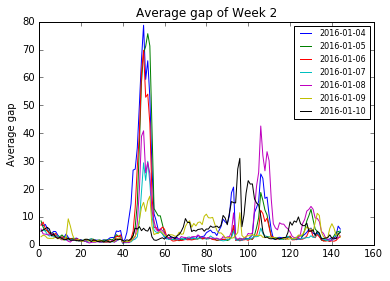

In [393]:
data_temp_week1 = full_order[full_order.date > '2016-01-03']
for date, drp in data_temp_week1[data_temp_week1.date < '2016-01-11'].groupby('date'):
    plt.plot(drp.groupby('time').gap.mean(), label=str(date))
    plt.title('Average gap of Week 2')
    plt.legend(loc=1, prop={'size':8})
    plt.xlabel('Time slots')
    plt.ylabel('Average gap')

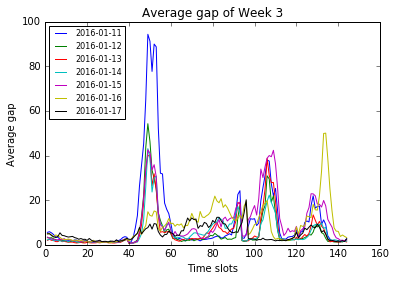

In [394]:
data_temp_week2 = full_order[full_order.date > '2016-01-10']
for date, drp in data_temp_week2[data_temp_week2.date < '2016-01-18'].groupby('date'):
    plt.plot(drp.groupby('time').gap.mean(), label=str(date))
    plt.title('Average gap of Week 3')
    plt.legend(loc=2,prop={'size':8})
    plt.xlabel('Time slots')
    plt.ylabel('Average gap')

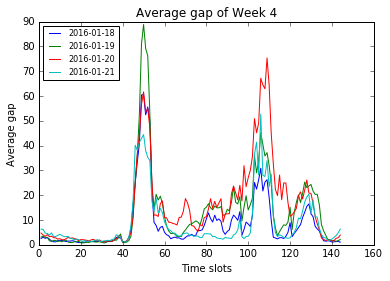

In [395]:
data_temp_week3 = full_order[full_order.date > '2016-01-17']
for date, drp in data_temp_week3.groupby('date'):
    plt.plot(drp.groupby('time').gap.mean(), label=str(date))
    plt.title('Average gap of Week 4')
    plt.legend(loc=2,prop={'size':8})
    plt.xlabel('Time slots')
    plt.ylabel('Average gap')

### Show the average gap of weekend or workday

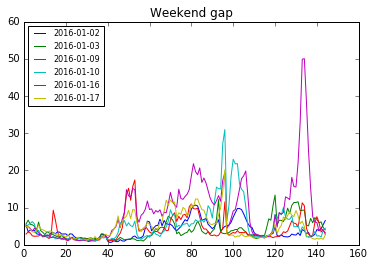

In [405]:
data_temp_weekend = full_order[full_order.week > 5]

for date, wgr in data_temp_weekend.groupby('date'):
    plt.plot(wgr.groupby('time').gap.mean(), label=str(date))
    plt.title('Weekend gap')
    plt.legend(loc=2,prop={'size':8})

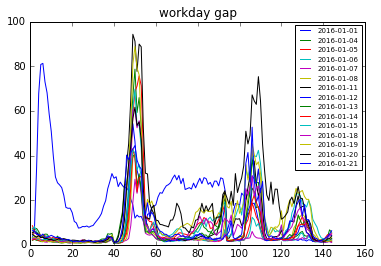

In [414]:
data_temp_notweekend = full_order[full_order.week < 6]

for date, wgr in data_temp_notweekend.groupby('date'):
    plt.plot(wgr.groupby('time').gap.mean(), label=str(date))
    plt.title('workday gap')
    plt.legend(loc=1,prop={'size':7})

In [480]:
full_order.describe()

,district_id,time,week,demand,supply,gap
count,199584.00000,199584.000000,199584.000000,199584.000000,199584.000000,199584.000000
mean,33.50000,72.500000,4.000000,43.288240,35.534271,7.753968
std,19.05042,41.568321,2.000005,103.541046,75.103888,45.220670
min,1.00000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,17.00000,36.750000,2.000000,2.000000,1.200000,0.000000
50%,33.50000,72.500000,4.000000,8.000000,6.000000,1.000000
75%,50.00000,108.250000,6.000000,32.000000,28.000000,3.000000
max,66.00000,144.000000,7.000000,4362.000000,1084.000000,3872.000000


In [491]:
gap_values_less_than_30 = full_order[full_order.gap < 31]

In [495]:
gap_values_less_than_30.describe()

,district_id,time,week,demand,supply,gap
count,191847.000000,191847.000000,191847.000000,191847.000000,191847.000000,191847.000000
mean,33.704004,72.355976,4.005411,30.498580,28.158765,2.339815
std,19.100338,41.857965,2.003141,61.698255,59.347323,4.234039
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,17.000000,36.000000,2.000000,2.000000,1.000000,0.000000
50%,34.000000,72.000000,4.000000,7.000000,6.000000,1.000000
75%,50.000000,109.000000,6.000000,26.000000,23.000000,2.000000
max,66.000000,144.000000,7.000000,779.000000,758.000000,30.750000


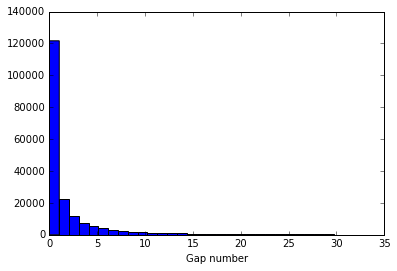

In [492]:
plt.hist(gap_values_less_than_30.gap,30);
plt.xlabel('Gap number');

### The data analysis 
- New Year's day holiday (Jan. 1-3). Jan. 3 is normal, Jan.1-2 delete

## Select data after 2016-01-03

In [428]:
full_order_selected = full_order[full_order.date > '2016-01-03']
full_order_selected[:2]

,district_id,time,date,week,demand,supply,gap
28512,1,1,2016-01-04,1,52.0,49.0,3.0
28513,1,2,2016-01-04,1,47.0,42.0,5.0


In [432]:
full_order_selected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171072 entries, 28512 to 199583
Data columns (total 7 columns):
district_id    171072 non-null int64
time           171072 non-null int64
date           171072 non-null object
week           171072 non-null int64
demand         171072 non-null float64
supply         171072 non-null float64
gap            171072 non-null float64
dtypes: float64(3), int64(3), object(1)
memory usage: 10.4+ MB


In [429]:
full_weather_selected = full_weather[full_weather.date > '2016-01-03']
full_weather_selected[:2]

,date,week,time,Weather,temperature,PM2.5
432,2016-01-04,1,1,2.0,13.0,187.0
433,2016-01-04,1,2,2.0,13.0,187.0


In [433]:
full_weather_selected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2592 entries, 432 to 3023
Data columns (total 6 columns):
date           2592 non-null object
week           2592 non-null int64
time           2592 non-null int64
Weather        2592 non-null float64
temperature    2592 non-null float64
PM2.5          2592 non-null float64
dtypes: float64(3), int64(2), object(1)
memory usage: 141.8+ KB


In [430]:
full_traffic_selected = full_traffic[full_traffic.date > '2016-01-03']
full_traffic_selected[:2]

,district_id,time,date,week,traffic_1,traffic_2,traffic_3,traffic_4
28512,1,1,2016-01-04,1,223.0,34.0,7.0,11.0
28513,1,2,2016-01-04,1,1110.0,184.0,51.0,45.0


In [431]:
full_traffic_selected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171072 entries, 28512 to 199583
Data columns (total 8 columns):
district_id    171072 non-null int64
time           171072 non-null int64
date           171072 non-null object
week           171072 non-null int64
traffic_1      171072 non-null float64
traffic_2      171072 non-null float64
traffic_3      171072 non-null float64
traffic_4      171072 non-null float64
dtypes: float64(4), int64(3), object(1)
memory usage: 11.7+ MB


## Simple prediction based on average gap in each time slot

### Average gap prediction

In [434]:
data_average_gap = full_order_selected.groupby(['district_id','week', 'time']).mean().reset_index()
data_average_gap.describe()

,district_id,week,time,demand,supply,gap
count,66528.000000,66528.000000,66528.000000,66528.000000,66528.000000,66528.000000
mean,33.500000,4.000000,72.500000,43.605530,36.177661,7.427869
std,19.050515,2.000015,41.568529,99.223224,75.422796,34.601723
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,17.000000,2.000000,36.750000,2.250000,1.500000,0.333333
50%,33.500000,4.000000,72.500000,7.666667,6.500000,1.000000
75%,50.000000,6.000000,108.250000,32.500000,28.500000,3.000000
max,66.000000,7.000000,144.000000,1413.500000,802.500000,963.000000


In [436]:
data_average_gap[:2]

,district_id,week,time,demand,supply,gap
0,1,1,1,69.333333,62.333333,7.0
1,1,1,2,55.666667,48.666667,7.0


In [447]:
test_order[:2]

,district_id,date,week,time,demand,supply,gap
0,1,2016-01-22,5,43,74,70.0,4.0
1,1,2016-01-22,5,44,128,127.0,1.0


In [455]:
# sp = simple prediction
gap_true_sp = test_order['gap']

In [456]:
simple_predictor = test_order.merge(data_average_gap, on = ['district_id','week', 'time'], how='left' )

In [457]:
simple_predictor[:2]

,district_id,date,week,time,demand_x,supply_x,gap_x,demand_y,supply_y,gap_y
0,1,2016-01-22,5,43,74,70.0,4.0,75.5,74.5,1.0
1,1,2016-01-22,5,44,128,127.0,1.0,113.5,112.0,1.5


In [458]:
gap_pred_sp = simple_predictor['gap_y']
gap_pred_sp[:2]

0    1.0
1    1.5
Name: gap_y, dtype: float64

In [459]:
MAPE(gap_pred_sp,gap_true_sp)

0.76846878304213651

### Predict the gap based on average gap

In [460]:
result = test_data.merge(data_average_gap, on = ['district_id','week', 'time'], how='left' )
result[:2]

,district_id,week,date,time,demand,supply,gap
0,1,5,2016-01-22,46,215.5,211.5,4.0
1,2,5,2016-01-22,46,26.5,26.0,0.5


In [461]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2838 entries, 0 to 2837
Data columns (total 7 columns):
district_id    2838 non-null int64
week           2838 non-null int64
date           2838 non-null object
time           2838 non-null int64
demand         2838 non-null float64
supply         2838 non-null float64
gap            2838 non-null float64
dtypes: float64(3), int64(3), object(1)
memory usage: 177.4+ KB


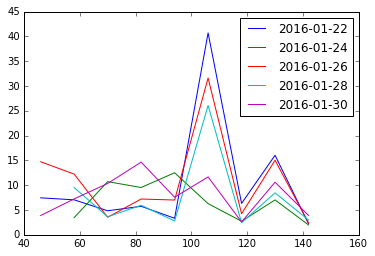

In [498]:
for date, drp in result.groupby('date'):
    plt.plot(drp.groupby('time').gap.mean(), label=str(date))
plt.legend()

In [463]:
# Reformat to meet the submit format
result['Time'] = result['date'].map(str) + '-' + result['time'].map(str)
result_data = result.loc[:, ['district_id', 'Time', 'gap']]
result_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2838 entries, 0 to 2837
Data columns (total 3 columns):
district_id    2838 non-null int64
Time           2838 non-null object
gap            2838 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 88.7+ KB


In [466]:
# Cehck
result_data[:5]

,district_id,Time,gap
0,1,2016-01-22-46,4.0
1,2,2016-01-22-46,0.5
2,3,2016-01-22-46,1.0
3,4,2016-01-22-46,3.0
4,5,2016-01-22-46,0.0


In [29]:
# The prediction result output as *.csv
result_data.to_csv('result0606.csv', index=False, header=False)

## Prediction using regressor

In [ ]:
# Merge all types of data into one dataframe.


In [ ]:
full_data = full_data.drop('date',axis = 1)
full_data[:2]

In [ ]:
order_data_selected = order_data_selected.drop('date',axis = 1)

In [ ]:
full_data.values[:,0:6]

In [ ]:
full_data.info()

In [ ]:
test_order.info()

In [ ]:
test_order[:2]

In [ ]:
#test_order = test_order.drop('date', axis =1)

#test_order = test_order.reindex(['district_id', 'week', 'time', 'date', 'demand', 'supply', 'gap'])
test_order1 = test_order.loc[:,['district_id', 'week', 'time','date', 'demand', 'supply', 'gap']]
test_order1[:2]

In [ ]:
full_data[:2]

In [ ]:
#full_data = order_data_selected.loc[:,['district_id', 'week', 'time','date', 'demand', 'supply', 'gap']]
#full_data[:2]

In [ ]:
#train_data = order_data_selected.loc[:,['district_id', 'week', 'time','date', 'demand', 'supply', 'gap']]
#train_data[:2]

In [ ]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(n_estimators=100, max_depth= 3)
clf.fit(order_data_selected.values[:,0:3], order_data_selected.values[:,5])

In [ ]:
from sklearn.tree import DecisionTreeRegressor
clf1 = DecisionTreeRegressor(max_depth = 10)
clf1.fit(order_data_selected.values[:,0:3], order_data_selected.values[:,5])

In [ ]:
from sklearn import svm
clf2 = svm.SVR()
clf2.fit(order_data_selected.values[:,0:3], order_data_selected.values[:,5])

In [ ]:
gap_pred = clf.predict(test_order1.values[:,0:3])
gap_true = test_order1.values[:,6]

MAPE(gap_pred, gap_true)

In [ ]:
gap_pred[:2]

In [ ]:
#test_temp = test_data.drop('date',axis=1)
test_temp[:2]

In [ ]:
result_pred = clf.predict(test_temp.values)

In [ ]:
result_pred.shape

In [ ]:
test_data[:2]

In [ ]:
test_data['gap'] = result_pred 

In [ ]:
test_data[:2]

In [ ]:
for date, drp in test_data.groupby('date'):
    plt.plot(drp.groupby('time').gap.mean(), label=str(date))
plt.legend()

In [ ]:
# Reformat to meet the submit format
test_data['Time'] = test_data['date'].map(str) + '-' + test_data['time'].map(str)
result_data = test_data.loc[:, ['district_id', 'Time', 'gap']]
result_data.info()

In [30]:
#check
result_data[:2]

,district_id,Time,gap
0,1,2016-01-22-46,4.0
1,2,2016-01-22-46,0.5


In [ ]:
# The prediction result output as *.csv
result_data.to_csv('result0605.csv', index=False, header=False)

In [40]:
size = result_data.shape[0]
vals = np.random.choice(size, size/100, replace=False)
vals

array([2760, 1031, 1169,  904, 2204, 1062,  493,  669, 1060, 2492, 1053,
       1080,  301,  534, 1205,  761, 1406,  790, 2708, 2695, 1270, 1607,
        891, 2205,  718, 2237,   97,  437])

In [53]:
n = len(full_data)
cols = list(set(full_data.index[1:n+1].intersection(result_data.columns).difference(['gap','week'])))
cols

[]

In [55]:
X = np.array(full_data[cols])
X[:2]

array([], shape=(2L, 0L), dtype=float64)

In [44]:
trains = list(set(xrange(size)).difference(vals))
#trains

In [45]:
result_data.columns

Index([u'district_id', u'Time', u'gap'], dtype='object')

In [ ]:
def train_val_split(X, y, index):
    train, val = [], []
    np.random.seed(5150)
    size = y.shape[0]
    vals = np.random.choice(size, size/100, replace=False)
    trains = list(set(xrange(size)).difference(vals))
    return X[trains, :], X[vals, :], y[trains], y[vals], index[trains, :], index[vals, :]

In [ ]:
n=len(pareto)

cols = (list(set(pareto.index[1:n+1]).intersection(test_data.columns)
                                   .difference(['y', 'district_ID', 'UTC', 'Interval'])))

X = np.array(training_data[cols])
y = np.array(training_data['y'])
index = np.array(training_data[['district_ID', 'UTC']]) #convert to np.array temporarily

X_train, X_val, y_train, y_val, _, index_vals = train_val_split(X, y, index)

index_val = pd.DataFrame(index_vals, columns=['district_ID', 'UTC'])

X_test = np.array(test_data[cols])
index_test = test_data[['district_ID', 'Interval']] #keep as pandas

### Traffic Data Analysis

In [86]:
import glob

train_traffic_path = os.path.join(TRAIN_DATA_DIR, TRAFFIC_SHEET_DIR)
test_traffic_path = os.path.join(TEST_DATA_DIR, TRAFFIC_SHEET_DIR)

train_traffic_files = glob.glob(os.path.join(train_traffic_path, "*.csv"))
test_traffic_files = glob.glob(os.path.join(test_traffic_path, "*.csv"))

# Load all the order data as train_order and test_order
train_traffic = pd.concat((pd.read_csv(f) for f in train_traffic_files))
test_traffic = pd.concat((pd.read_csv(f) for f in test_traffic_files))

ValueError: No objects to concatenate

In [ ]:
train_traffic.head()